# Connect to Trader Workstation 
** from Interactive Brokers (testing use port 7497 for paper trading account.) **

In [107]:
# common imports
import numpy as np
import os

from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=3)

<IB connected to 127.0.0.1:7497 clientId=3>

Test for connection

In [151]:
ib.isConnected()

True

Select the Stock we wish to model.

In [109]:

contract = Stock('TSLA', 'SMART', 'USD')
# shows date of first available historical data (how far back we can model).
ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

In [39]:
# TRADES HISTORICAL_VOLATILITY OPTION_IMPLIED_VOLATILITY

In [110]:
trade_data = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

 Option implied volitiilty data 

In [111]:
option_implied_vol = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='90 D',
        barSizeSetting='1 min',
        whatToShow='OPTION_IMPLIED_VOLATILITY',
        useRTH=True,
        formatDate=1)

In [112]:
option_implied_vol[0]
# trade_data[0]

BarData(date=datetime.datetime(2018, 4, 9, 6, 30), open=0.59865944, high=0.59865944, low=0.59865944, close=0.59865944, average=0.59865944)

Helper function to ready data

In [145]:
def data_prep(trade_data, option_implied_vol):
    # convert into dataframes 
    df_trades = util.df(trade_data)
    df_optImpVol = util.df(option_implied_vol)
    # remove empty colums (volume, barcount) and rename columns so they dont conflict with Trades
    df_optImpVol.drop(columns=['volume', 'barCount'], inplace=True)
    # Rename cols
    df_optImpVol.rename(index=str, columns={"open": "volOpen", "high":"volHigh", "low":"volLow", "close":"volClose", "average":"volAverage"})
    # Merge datasets
    df_merged = df_trades.merge(df_optImpVol, left_on='date', right_on='date', how='outer')
    #  add new columns and normalize data. 
    #  ROC_min = close_x - open_x / open_x * 100    # Rate of change per minute
    df_merged['ROC_min'] = ( df_merged['close_x'] - df_merged['open_x'] ) / ( df_merged['open_x']  ) 
    #  perMinVol = high_x - low_x / low_x * 100     # intra minute spread volitity
    df_merged['perMinVol'] = ( df_merged['high_x'] - df_merged['low_x'] ) / df_merged['low_x'] 
    # adding 7day rolling mean for price 
    df_merged['rollMean_7day'] = df_merged['close_x'].rolling(2940).mean()
    # drop unwanted columns: open_x, high_x, low_x, average_x, open_y, hight_y, low_y, average_y 
    df_merged.drop(columns=['date','open_x', 'high_x', 'low_x', 'average_x', 'open_y', 'high_y', 'low_y', 'average_y'], inplace=True)
#     # Rename cols
#     df_merged.rename(index=str, columns={"close_x":"price_close", "close_y":"avgMinVol"})
#     df_merged.head(3)

    return df_merged



In [172]:
df = data_prep(trade_data, option_implied_vol)
print(df.shape)
print(df.head(3))
# remove the NaN's from rollMean_7day
df = df[2950 : ]
print(df.shape)
print(df.head(3))


(34785, 7)
   close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
0   303.02  1212.0     318.0  0.598659  0.007246   0.009757            NaN
1   303.09   549.0     228.0  0.619233 -0.000099   0.003171            NaN
2   303.08   541.0     332.0  0.619233 -0.000264   0.006863            NaN
(31835, 7)
      close_x  volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
2950   293.14    26.0       6.0  0.555894 -0.000034   0.000785     297.751857
2951   293.22    31.0      17.0  0.555894  0.000614   0.000887     297.748748
2952   293.59    34.0      29.0  0.555894  0.001262   0.001467     297.745888


In [173]:
#  split data by taking first 80% of rows for training last 20% for testing. 

n = df.shape
train_len = int(n[0] * .8)
test_len = n[0] - train_len
df_train = df[0: train_len]
df_test = df[train_len : n[0]]
print(df_train.shape)
print(df_test.shape)
# df_test = df[:10]
# df_test.shape
# df_test.head(9)
df.head(2)


(25468, 7)
(6367, 7)


,close_x,volume,barCount,close_y,ROC_min,perMinVol,rollMean_7day
2950,293.14,26.0,6.0,0.555894,-0.000034,0.000785,297.751857
2951,293.22,31.0,17.0,0.555894,0.000614,0.000887,297.748748


In [174]:
# # # define test_x test_y train_x train_y
test_x = df_test.filter(['volume','barCount','close_y', 'ROC_min', 'perMinVol', 'rollMean_7day'], axis=1)
test_y = df_test.filter(['close_x'], axis=1)

train_x = df_train.filter(['volume','barCount','close_y','ROC_min','perMinVol','rollMean_7day'], axis=1)
train_y = df_train.filter(['close_x'], axis=1)

print(train_x.head(2))

# # train_y = df_train['close_x']

 


      volume  barCount   close_y   ROC_min  perMinVol  rollMean_7day
2950    26.0       6.0  0.555894 -0.000034   0.000785     297.751857
2951    31.0      17.0  0.555894  0.000614   0.000887     297.748748


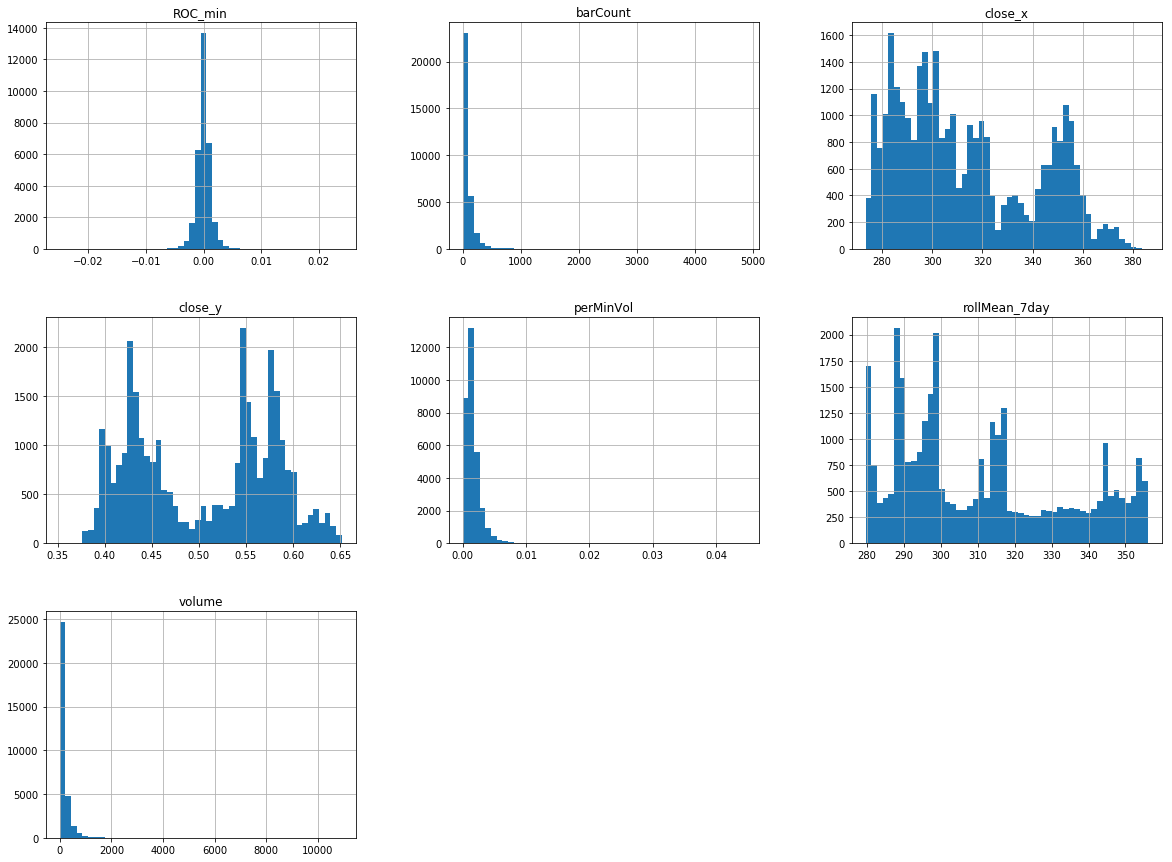

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))

plt.show()

In [179]:
#  bring in the sklearn. MLP 
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(train_x, train_y)  


/Users/lorinfields/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([293.14, 293.22, 293.59, ..., 301.49, 301.8 , 301.64]),)

In [110]:
ib.disconnect()